In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=1e-3
LEARNING_RATE = .0001

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 500 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


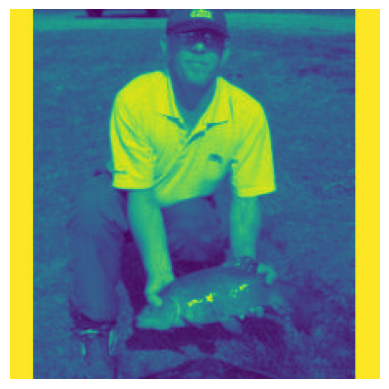

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parametrs: ", count_parameters(model))


Total parametrs:  24511329


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000100, Loss: 0.9385


Epoch 1, Batch 2, LR: 0.000100, Loss: 0.9598


Epoch 1, Batch 3, LR: 0.000100, Loss: 0.7382


Epoch 1, Batch 4, LR: 0.000100, Loss: 0.7082


Epoch 1, Batch 5, LR: 0.000100, Loss: 0.6729


Epoch 1, Batch 6, LR: 0.000100, Loss: 0.6567


Epoch 1, Batch 7, LR: 0.000100, Loss: 0.6350


Epoch 1, Batch 8, LR: 0.000100, Loss: 0.6175


Epoch 1, Batch 9, LR: 0.000100, Loss: 0.6236


Epoch 1, Batch 10, LR: 0.000100, Loss: 0.5986


Epoch 1, Batch 11, LR: 0.000100, Loss: 0.6099


Epoch 1, Batch 12, LR: 0.000100, Loss: 0.6140


Epoch 1, Batch 13, LR: 0.000100, Loss: 0.6027


Epoch 1, Batch 14, LR: 0.000100, Loss: 0.5805


Epoch 1, Batch 15, LR: 0.000100, Loss: 0.5985


Epoch 1, Batch 16, LR: 0.000100, Loss: 0.5893


Epoch 1, Batch 17, LR: 0.000100, Loss: 0.5779


Epoch 1, Batch 18, LR: 0.000100, Loss: 0.5933


Epoch 1, Batch 19, LR: 0.000100, Loss: 0.5745


Epoch 1, Batch 20, LR: 0.000100, Loss: 0.5743


Epoch 1, Batch 21, LR: 0.000100, Loss: 0.5827


Epoch 1, Batch 22, LR: 0.000100, Loss: 0.5968


Epoch 1, Batch 23, LR: 0.000099, Loss: 0.6001


Epoch 1, Batch 24, LR: 0.000099, Loss: 0.6148


Epoch 1, Batch 25, LR: 0.000099, Loss: 0.5979


Epoch 1, Batch 26, LR: 0.000099, Loss: 0.5957


Epoch 1, Batch 27, LR: 0.000099, Loss: 0.5901


Epoch 1, Batch 28, LR: 0.000099, Loss: 0.6004


Epoch 1, Batch 29, LR: 0.000099, Loss: 0.5947


Epoch 1, Batch 30, LR: 0.000099, Loss: 0.5944


Epoch 1, Batch 31, LR: 0.000099, Loss: 0.5590


Epoch 1, Batch 32, LR: 0.000099, Loss: 0.5766


Epoch 1, Batch 33, LR: 0.000099, Loss: 0.5891


Epoch 1, Batch 34, LR: 0.000099, Loss: 0.5945


Epoch 1, Batch 35, LR: 0.000099, Loss: 0.5196


Epoch 1, Batch 36, LR: 0.000099, Loss: 0.5416


Epoch 1, Batch 37, LR: 0.000099, Loss: 0.5479


Epoch 1, Batch 38, LR: 0.000099, Loss: 0.5760


Epoch 1, Batch 39, LR: 0.000099, Loss: 0.6151


Epoch 1, Batch 40, LR: 0.000098, Loss: 0.5756


Epoch 1, Batch 41, LR: 0.000098, Loss: 0.6139


Epoch 1, Batch 42, LR: 0.000098, Loss: 0.5979


Epoch 1, Batch 43, LR: 0.000098, Loss: 0.6094


Epoch 1, Batch 44, LR: 0.000098, Loss: 0.5951


Epoch 1, Batch 45, LR: 0.000098, Loss: 0.6135


Epoch 1, Batch 46, LR: 0.000098, Loss: 0.6103


Epoch 1, Batch 47, LR: 0.000098, Loss: 0.6014


Epoch 1, Batch 48, LR: 0.000098, Loss: 0.6028


Epoch 1, Batch 49, LR: 0.000098, Loss: 0.6063


Epoch 1, Batch 50, LR: 0.000098, Loss: 0.5953


Epoch 1, Batch 51, LR: 0.000097, Loss: 0.6008


Epoch 1, Batch 52, LR: 0.000097, Loss: 0.5999


Epoch 1, Batch 53, LR: 0.000097, Loss: 0.5848


Epoch 1, Batch 54, LR: 0.000097, Loss: 0.5984


Epoch 1, Batch 55, LR: 0.000097, Loss: 0.6076


Epoch 1, Batch 56, LR: 0.000097, Loss: 0.6073


Epoch 1, Batch 57, LR: 0.000097, Loss: 0.5984


Epoch 1, Batch 58, LR: 0.000097, Loss: 0.6113


Epoch 1, Batch 59, LR: 0.000097, Loss: 0.6073


Epoch 1, Batch 60, LR: 0.000096, Loss: 0.6040


Epoch 1, Batch 61, LR: 0.000096, Loss: 0.6064


Epoch 1, Batch 62, LR: 0.000096, Loss: 0.5853


Epoch 1, Batch 63, LR: 0.000096, Loss: 0.5849


Epoch 1, Batch 64, LR: 0.000096, Loss: 0.5791


Epoch 1, Batch 65, LR: 0.000096, Loss: 0.6059


Epoch 1, Batch 66, LR: 0.000096, Loss: 0.6001


Epoch 1, Batch 67, LR: 0.000096, Loss: 0.5960


Epoch 1, Batch 68, LR: 0.000096, Loss: 0.5871


Epoch 1, Batch 69, LR: 0.000095, Loss: 0.5911


Epoch 1, Batch 70, LR: 0.000095, Loss: 0.6049


Epoch 1, Batch 71, LR: 0.000095, Loss: 0.5912


Epoch 1, Batch 72, LR: 0.000095, Loss: 0.5760


Epoch 1, Batch 73, LR: 0.000095, Loss: 0.5833


Epoch 1, Batch 74, LR: 0.000095, Loss: 0.5919


Epoch 1, Batch 75, LR: 0.000095, Loss: 0.6085


Epoch 1, Batch 76, LR: 0.000094, Loss: 0.5965


Epoch 1, Batch 77, LR: 0.000094, Loss: 0.5897


Epoch 1, Batch 78, LR: 0.000094, Loss: 0.5964


Epoch 1, Batch 79, LR: 0.000094, Loss: 0.5968


Epoch 1, Batch 80, LR: 0.000094, Loss: 0.5813


Epoch 1, Batch 81, LR: 0.000094, Loss: 0.5959


Epoch 1, Batch 82, LR: 0.000094, Loss: 0.5867


Epoch 1, Batch 83, LR: 0.000093, Loss: 0.5815


Epoch 1, Batch 84, LR: 0.000093, Loss: 0.5925


Epoch 1, Batch 85, LR: 0.000093, Loss: 0.5788


Epoch 1, Batch 86, LR: 0.000093, Loss: 0.5834


Epoch 1, Batch 87, LR: 0.000093, Loss: 0.5921


Epoch 1, Batch 88, LR: 0.000093, Loss: 0.5782


Epoch 1, Batch 89, LR: 0.000092, Loss: 0.5652


Epoch 1, Batch 90, LR: 0.000092, Loss: 0.5596


Epoch 1, Batch 91, LR: 0.000092, Loss: 0.5596


Epoch 1, Batch 92, LR: 0.000092, Loss: 0.5782


Epoch 1, Batch 93, LR: 0.000092, Loss: 0.5792


Epoch 1, Batch 94, LR: 0.000092, Loss: 0.5699


Epoch 1, Batch 95, LR: 0.000091, Loss: 0.5870


Epoch 1, Batch 96, LR: 0.000091, Loss: 0.5877


Epoch 1, Batch 97, LR: 0.000091, Loss: 0.5818


Epoch 1, Batch 98, LR: 0.000091, Loss: 0.5756


Epoch 1, Batch 99, LR: 0.000091, Loss: 0.5651


Epoch 1, Batch 100, LR: 0.000090, Loss: 0.5857


Epoch 1, Batch 101, LR: 0.000090, Loss: 0.5887


Epoch 1, Batch 102, LR: 0.000090, Loss: 0.5761


Epoch 1, Batch 103, LR: 0.000090, Loss: 0.5480


Epoch 1, Batch 104, LR: 0.000090, Loss: 0.5402


Epoch 1, Batch 105, LR: 0.000090, Loss: 0.5627


Epoch 1, Batch 106, LR: 0.000089, Loss: 0.5718


Epoch 1, Batch 107, LR: 0.000089, Loss: 0.6034


Epoch 1, Batch 108, LR: 0.000089, Loss: 0.5986


Epoch 1, Batch 109, LR: 0.000089, Loss: 0.5932


Epoch 1, Batch 110, LR: 0.000089, Loss: 0.5967


Epoch 1, Batch 111, LR: 0.000088, Loss: 0.5183


Epoch 1, Batch 112, LR: 0.000088, Loss: 0.5493


Epoch 1, Batch 113, LR: 0.000088, Loss: 0.5464


Epoch 1, Batch 114, LR: 0.000088, Loss: 0.5768


Epoch 1, Batch 115, LR: 0.000088, Loss: 0.5256


Epoch 1, Batch 116, LR: 0.000087, Loss: 0.5614


Epoch 1, Batch 117, LR: 0.000087, Loss: 0.5602


Epoch 1, Batch 118, LR: 0.000087, Loss: 0.5479


Epoch 1, Batch 119, LR: 0.000087, Loss: 0.5143


Epoch 1, Batch 120, LR: 0.000086, Loss: 0.5729


Epoch 1, Batch 121, LR: 0.000086, Loss: 0.5479


Epoch 1, Batch 122, LR: 0.000086, Loss: 0.5579


Epoch 1, Batch 123, LR: 0.000086, Loss: 0.6391


Epoch 1, Batch 124, LR: 0.000086, Loss: 0.6148


Epoch 1, Batch 125, LR: 0.000085, Loss: 0.6143


Epoch 1, Batch 126, LR: 0.000085, Loss: 0.6198


Epoch 1, Batch 127, LR: 0.000085, Loss: 0.6171


Epoch 1, Batch 128, LR: 0.000085, Loss: 0.6161


Epoch 1, Batch 129, LR: 0.000084, Loss: 0.6332


Epoch 1, Batch 130, LR: 0.000084, Loss: 0.6139


Epoch 1, Batch 131, LR: 0.000084, Loss: 0.6161


Epoch 1, Batch 132, LR: 0.000084, Loss: 0.6062


Epoch 1, Batch 133, LR: 0.000084, Loss: 0.6239


Epoch 1, Batch 134, LR: 0.000083, Loss: 0.6076


Epoch 1, Batch 135, LR: 0.000083, Loss: 0.6109


Epoch 1, Batch 136, LR: 0.000083, Loss: 0.6189


Epoch 1, Batch 137, LR: 0.000083, Loss: 0.6197


Epoch 1, Batch 138, LR: 0.000082, Loss: 0.6211


Epoch 1, Batch 139, LR: 0.000082, Loss: 0.6182


Epoch 1, Batch 140, LR: 0.000082, Loss: 0.6208


Epoch 1, Batch 141, LR: 0.000082, Loss: 0.6177


Epoch 1, Batch 142, LR: 0.000081, Loss: 0.5833


Epoch 1, Batch 143, LR: 0.000081, Loss: 0.5843


Epoch 1, Batch 144, LR: 0.000081, Loss: 0.5772


Epoch 1, Batch 145, LR: 0.000081, Loss: 0.5557


Epoch 1, Batch 146, LR: 0.000080, Loss: 0.5733


Epoch 1, Batch 147, LR: 0.000080, Loss: 0.5671


Epoch 1, Batch 148, LR: 0.000080, Loss: 0.5758


Epoch 1, Batch 149, LR: 0.000080, Loss: 0.5674


Epoch 1, Batch 150, LR: 0.000079, Loss: 0.5613


Epoch 1, Batch 151, LR: 0.000079, Loss: 0.5587


Epoch 1, Batch 152, LR: 0.000079, Loss: 0.5608


Epoch 1, Batch 153, LR: 0.000079, Loss: 0.5577


Epoch 1, Batch 154, LR: 0.000078, Loss: 0.5580


Epoch 1, Batch 155, LR: 0.000078, Loss: 0.5632


Epoch 1, Batch 156, LR: 0.000078, Loss: 0.5610


Epoch 1, Batch 157, LR: 0.000078, Loss: 0.5714


Epoch 1, Batch 158, LR: 0.000077, Loss: 0.5591


Epoch 1, Batch 159, LR: 0.000077, Loss: 0.5559


Epoch 1, Batch 160, LR: 0.000077, Loss: 0.5634


Epoch 1, Batch 161, LR: 0.000077, Loss: 0.5558


Epoch 1, Batch 162, LR: 0.000076, Loss: 0.5595


Epoch 1, Batch 163, LR: 0.000076, Loss: 0.5702


Epoch 1, Batch 164, LR: 0.000076, Loss: 0.5676


Epoch 1, Batch 165, LR: 0.000075, Loss: 0.5547


Epoch 1, Batch 166, LR: 0.000075, Loss: 0.5690


Epoch 1, Batch 167, LR: 0.000075, Loss: 0.5671


Epoch 1, Batch 168, LR: 0.000075, Loss: 0.5680


Epoch 1, Batch 169, LR: 0.000074, Loss: 0.5730


Epoch 1, Batch 170, LR: 0.000074, Loss: 0.5744


Epoch 1, Batch 171, LR: 0.000074, Loss: 0.5878


Epoch 1, Batch 172, LR: 0.000074, Loss: 0.5767


Epoch 1, Batch 173, LR: 0.000073, Loss: 0.5907


Epoch 1, Batch 174, LR: 0.000073, Loss: 0.5801


Epoch 1, Batch 175, LR: 0.000073, Loss: 0.5715


Epoch 1, Batch 176, LR: 0.000072, Loss: 0.5681


Epoch 1, Batch 177, LR: 0.000072, Loss: 0.5788


Epoch 1, Batch 178, LR: 0.000072, Loss: 0.5739


Epoch 1, Batch 179, LR: 0.000072, Loss: 0.5741


Epoch 1, Batch 180, LR: 0.000071, Loss: 0.5545


Epoch 1, Batch 181, LR: 0.000071, Loss: 0.5760


Epoch 1, Batch 182, LR: 0.000071, Loss: 0.5801


Epoch 1, Batch 183, LR: 0.000070, Loss: 0.5759


Epoch 1, Batch 184, LR: 0.000070, Loss: 0.5782


Epoch 1, Batch 185, LR: 0.000070, Loss: 0.5822


Epoch 1, Batch 186, LR: 0.000070, Loss: 0.5670


Epoch 1, Batch 187, LR: 0.000069, Loss: 0.5755


Epoch 1, Batch 188, LR: 0.000069, Loss: 0.5715


Epoch 1, Batch 189, LR: 0.000069, Loss: 0.5623


Epoch 1, Batch 190, LR: 0.000068, Loss: 0.5836


Epoch 1, Batch 191, LR: 0.000068, Loss: 0.5786


Epoch 1, Batch 192, LR: 0.000068, Loss: 0.5903


Epoch 1, Batch 193, LR: 0.000068, Loss: 0.5698


Epoch 1, Batch 194, LR: 0.000067, Loss: 0.5846


Epoch 1, Batch 195, LR: 0.000067, Loss: 0.5721


Epoch 1, Batch 196, LR: 0.000067, Loss: 0.5950


Epoch 1, Batch 197, LR: 0.000066, Loss: 0.5848


Epoch 1, Batch 198, LR: 0.000066, Loss: 0.5717


Epoch 1, Batch 199, LR: 0.000066, Loss: 0.5691


Epoch 1, Batch 200, LR: 0.000065, Loss: 0.5815


Epoch 1, Batch 201, LR: 0.000065, Loss: 0.5679


Epoch 1, Batch 202, LR: 0.000065, Loss: 0.5465


Epoch 1, Batch 203, LR: 0.000065, Loss: 0.5754


Epoch 1, Batch 204, LR: 0.000064, Loss: 0.5925


Epoch 1, Batch 205, LR: 0.000064, Loss: 0.6056


Epoch 1, Batch 206, LR: 0.000064, Loss: 0.6059


Epoch 1, Batch 207, LR: 0.000063, Loss: 0.5981


Epoch 1, Batch 208, LR: 0.000063, Loss: 0.5821


Epoch 1, Batch 209, LR: 0.000063, Loss: 0.5710


Epoch 1, Batch 210, LR: 0.000062, Loss: 0.5688


Epoch 1, Batch 211, LR: 0.000062, Loss: 0.5690


Epoch 1, Batch 212, LR: 0.000062, Loss: 0.5400


Epoch 1, Batch 213, LR: 0.000062, Loss: 0.5742


Epoch 1, Batch 214, LR: 0.000061, Loss: 0.5628


Epoch 1, Batch 215, LR: 0.000061, Loss: 0.5587


Epoch 1, Batch 216, LR: 0.000061, Loss: 0.5722


Epoch 1, Batch 217, LR: 0.000060, Loss: 0.5734


Epoch 1, Batch 218, LR: 0.000060, Loss: 0.5691


Epoch 1, Batch 219, LR: 0.000060, Loss: 0.5537


Epoch 1, Batch 220, LR: 0.000059, Loss: 0.5485


Epoch 1, Batch 221, LR: 0.000059, Loss: 0.5537


Epoch 1, Batch 222, LR: 0.000059, Loss: 0.5527


Epoch 1, Batch 223, LR: 0.000058, Loss: 0.5541


Epoch 1, Batch 224, LR: 0.000058, Loss: 0.5756


Epoch 1, Batch 225, LR: 0.000058, Loss: 0.5673


Epoch 1, Batch 226, LR: 0.000058, Loss: 0.5883


Epoch 1, Batch 227, LR: 0.000057, Loss: 0.5979


Epoch 1, Batch 228, LR: 0.000057, Loss: 0.5779


Epoch 1, Batch 229, LR: 0.000057, Loss: 0.5968


Epoch 1, Batch 230, LR: 0.000056, Loss: 0.5964


Epoch 1, Batch 231, LR: 0.000056, Loss: 0.6038


Epoch 1, Batch 232, LR: 0.000056, Loss: 0.5832


Epoch 1, Batch 233, LR: 0.000055, Loss: 0.6014


Epoch 1, Batch 234, LR: 0.000055, Loss: 0.6001


Epoch 1, Batch 235, LR: 0.000055, Loss: 0.5940


Epoch 1, Batch 236, LR: 0.000054, Loss: 0.5821


Epoch 1, Batch 237, LR: 0.000054, Loss: 0.5873


Epoch 1, Batch 238, LR: 0.000054, Loss: 0.5993


Epoch 1, Batch 239, LR: 0.000053, Loss: 0.5899


Epoch 1, Batch 240, LR: 0.000053, Loss: 0.5913


Epoch 1, Batch 241, LR: 0.000053, Loss: 0.5932


Epoch 1, Batch 242, LR: 0.000053, Loss: 0.5739


Epoch 1, Batch 243, LR: 0.000052, Loss: 0.5908


Epoch 1, Batch 244, LR: 0.000052, Loss: 0.5901


Epoch 1, Batch 245, LR: 0.000052, Loss: 0.6004


Epoch 1, Batch 246, LR: 0.000051, Loss: 0.5925


Epoch 1, Batch 247, LR: 0.000051, Loss: 0.6029


Epoch 1, Batch 248, LR: 0.000051, Loss: 0.5938


Epoch 1, Batch 249, LR: 0.000050, Loss: 0.6027


Epoch 1, Batch 250, LR: 0.000050, Loss: 0.5913


Epoch 1, Batch 251, LR: 0.000050, Loss: 0.6094


Epoch 1, Batch 252, LR: 0.000049, Loss: 0.6027


Epoch 1, Batch 253, LR: 0.000049, Loss: 0.6085


Epoch 1, Batch 254, LR: 0.000049, Loss: 0.6004


Epoch 1, Batch 255, LR: 0.000048, Loss: 0.5923


Epoch 1, Batch 256, LR: 0.000048, Loss: 0.5814


Epoch 1, Batch 257, LR: 0.000048, Loss: 0.6043


Epoch 1, Batch 258, LR: 0.000047, Loss: 0.6004


Epoch 1, Batch 259, LR: 0.000047, Loss: 0.5992


Epoch 1, Batch 260, LR: 0.000047, Loss: 0.5926


Epoch 1, Batch 261, LR: 0.000047, Loss: 0.5863


Epoch 1, Batch 262, LR: 0.000046, Loss: 0.6071


Epoch 1, Batch 263, LR: 0.000046, Loss: 0.5905


Epoch 1, Batch 264, LR: 0.000046, Loss: 0.5969


Epoch 1, Batch 265, LR: 0.000045, Loss: 0.6032


Epoch 1, Batch 266, LR: 0.000045, Loss: 0.5702


Epoch 1, Batch 267, LR: 0.000045, Loss: 0.5902


Epoch 1, Batch 268, LR: 0.000044, Loss: 0.5824


Epoch 1, Batch 269, LR: 0.000044, Loss: 0.5764


Epoch 1, Batch 270, LR: 0.000044, Loss: 0.5926


Epoch 1, Batch 271, LR: 0.000043, Loss: 0.5975


Epoch 1, Batch 272, LR: 0.000043, Loss: 0.5859


Epoch 1, Batch 273, LR: 0.000043, Loss: 0.5813


Epoch 1, Batch 274, LR: 0.000042, Loss: 0.6047


Epoch 1, Batch 275, LR: 0.000042, Loss: 0.5887


Epoch 1, Batch 276, LR: 0.000042, Loss: 0.5928


Epoch 1, Batch 277, LR: 0.000042, Loss: 0.5852


Epoch 1, Batch 278, LR: 0.000041, Loss: 0.5782


Epoch 1, Batch 279, LR: 0.000041, Loss: 0.6040


Epoch 1, Batch 280, LR: 0.000041, Loss: 0.5974


Epoch 1, Batch 281, LR: 0.000040, Loss: 0.5748


Epoch 1, Batch 282, LR: 0.000040, Loss: 0.6034


Epoch 1, Batch 283, LR: 0.000040, Loss: 0.5983


Epoch 1, Batch 284, LR: 0.000039, Loss: 0.5892


Epoch 1, Batch 285, LR: 0.000039, Loss: 0.6072


Epoch 1, Batch 286, LR: 0.000039, Loss: 0.5933


Epoch 1, Batch 287, LR: 0.000038, Loss: 0.6067


Epoch 1, Batch 288, LR: 0.000038, Loss: 0.6064


Epoch 1, Batch 289, LR: 0.000038, Loss: 0.6002


Epoch 1, Batch 290, LR: 0.000038, Loss: 0.6079


Epoch 1, Batch 291, LR: 0.000037, Loss: 0.6075


Epoch 1, Batch 292, LR: 0.000037, Loss: 0.6014


Epoch 1, Batch 293, LR: 0.000037, Loss: 0.5934


Epoch 1, Batch 294, LR: 0.000036, Loss: 0.6079


Epoch 1, Batch 295, LR: 0.000036, Loss: 0.6015


Epoch 1, Batch 296, LR: 0.000036, Loss: 0.6046


Epoch 1, Batch 297, LR: 0.000035, Loss: 0.6139


Epoch 1, Batch 298, LR: 0.000035, Loss: 0.5976


Epoch 1, Batch 299, LR: 0.000035, Loss: 0.6046


Epoch 1, Batch 300, LR: 0.000035, Loss: 0.6133


Epoch 1, Batch 301, LR: 0.000034, Loss: 0.6015


Epoch 1, Batch 302, LR: 0.000034, Loss: 0.5972


Epoch 1, Batch 303, LR: 0.000034, Loss: 0.6138


Epoch 1, Batch 304, LR: 0.000033, Loss: 0.6178


Epoch 1, Batch 305, LR: 0.000033, Loss: 0.5945


Epoch 1, Batch 306, LR: 0.000033, Loss: 0.6131


Epoch 1, Batch 307, LR: 0.000032, Loss: 0.6080


Epoch 1, Batch 308, LR: 0.000032, Loss: 0.5769


Epoch 1, Batch 309, LR: 0.000032, Loss: 0.5960


Epoch 1, Batch 310, LR: 0.000032, Loss: 0.6024


Epoch 1, Batch 311, LR: 0.000031, Loss: 0.5873


Epoch 1, Batch 312, LR: 0.000031, Loss: 0.5932


Epoch 1, Batch 313, LR: 0.000031, Loss: 0.6063


Epoch 1, Batch 314, LR: 0.000030, Loss: 0.5908


Epoch 1, Batch 315, LR: 0.000030, Loss: 0.6065


Epoch 1, Batch 316, LR: 0.000030, Loss: 0.5930


Epoch 1, Batch 317, LR: 0.000030, Loss: 0.5910


Epoch 1, Batch 318, LR: 0.000029, Loss: 0.5997


Epoch 1, Batch 319, LR: 0.000029, Loss: 0.5877


Epoch 1, Batch 320, LR: 0.000029, Loss: 0.6070


Epoch 1, Batch 321, LR: 0.000028, Loss: 0.6019


Epoch 1, Batch 322, LR: 0.000028, Loss: 0.5941


Epoch 1, Batch 323, LR: 0.000028, Loss: 0.6020


Epoch 1, Batch 324, LR: 0.000028, Loss: 0.5902


Epoch 1, Batch 325, LR: 0.000027, Loss: 0.6061


Epoch 1, Batch 326, LR: 0.000027, Loss: 0.5842


Epoch 1, Batch 327, LR: 0.000027, Loss: 0.5853


Epoch 1, Batch 328, LR: 0.000026, Loss: 0.5955


Epoch 1, Batch 329, LR: 0.000026, Loss: 0.5860


Epoch 1, Batch 330, LR: 0.000026, Loss: 0.5847


Epoch 1, Batch 331, LR: 0.000026, Loss: 0.5984


Epoch 1, Batch 332, LR: 0.000025, Loss: 0.5836


Epoch 1, Batch 333, LR: 0.000025, Loss: 0.5816


Epoch 1, Batch 334, LR: 0.000025, Loss: 0.5891


Epoch 1, Batch 335, LR: 0.000025, Loss: 0.5959


Epoch 1, Batch 336, LR: 0.000024, Loss: 0.5788


Epoch 1, Batch 337, LR: 0.000024, Loss: 0.5781


Epoch 1, Batch 338, LR: 0.000024, Loss: 0.5903


Epoch 1, Batch 339, LR: 0.000023, Loss: 0.5730


Epoch 1, Batch 340, LR: 0.000023, Loss: 0.5763


Epoch 1, Batch 341, LR: 0.000023, Loss: 0.5980


Epoch 1, Batch 342, LR: 0.000023, Loss: 0.6012


Epoch 1, Batch 343, LR: 0.000022, Loss: 0.5791


Epoch 1, Batch 344, LR: 0.000022, Loss: 0.5949


Epoch 1, Batch 345, LR: 0.000022, Loss: 0.5908


Epoch 1, Batch 346, LR: 0.000022, Loss: 0.5888


Epoch 1, Batch 347, LR: 0.000021, Loss: 0.5904


Epoch 1, Batch 348, LR: 0.000021, Loss: 0.5931


Epoch 1, Batch 349, LR: 0.000021, Loss: 0.6067


Epoch 1, Batch 350, LR: 0.000021, Loss: 0.5892


Epoch 1, Batch 351, LR: 0.000020, Loss: 0.5920


Epoch 1, Batch 352, LR: 0.000020, Loss: 0.5868


Epoch 1, Batch 353, LR: 0.000020, Loss: 0.5884


Epoch 1, Batch 354, LR: 0.000020, Loss: 0.5911


Epoch 1, Batch 355, LR: 0.000019, Loss: 0.5864


Epoch 1, Batch 356, LR: 0.000019, Loss: 0.6047


Epoch 1, Batch 357, LR: 0.000019, Loss: 0.5852


Epoch 1, Batch 358, LR: 0.000019, Loss: 0.5846


Epoch 1, Batch 359, LR: 0.000018, Loss: 0.5899


Epoch 1, Batch 360, LR: 0.000018, Loss: 0.5918


Epoch 1, Batch 361, LR: 0.000018, Loss: 0.5876


Epoch 1, Batch 362, LR: 0.000018, Loss: 0.5972


Epoch 1, Batch 363, LR: 0.000017, Loss: 0.5783


Epoch 1, Batch 364, LR: 0.000017, Loss: 0.5959


Epoch 1, Batch 365, LR: 0.000017, Loss: 0.5885


Epoch 1, Batch 366, LR: 0.000017, Loss: 0.5734


Epoch 1, Batch 367, LR: 0.000016, Loss: 0.5766


Epoch 1, Batch 368, LR: 0.000016, Loss: 0.5508


Epoch 1, Batch 369, LR: 0.000016, Loss: 0.5556


Epoch 1, Batch 370, LR: 0.000016, Loss: 0.5485


Epoch 1, Batch 371, LR: 0.000016, Loss: 0.5478


Epoch 1, Batch 372, LR: 0.000015, Loss: 0.5619


Epoch 1, Batch 373, LR: 0.000015, Loss: 0.5551


Epoch 1, Batch 374, LR: 0.000015, Loss: 0.5522


Epoch 1, Batch 375, LR: 0.000015, Loss: 0.5516


Epoch 1, Batch 376, LR: 0.000014, Loss: 0.5649


Epoch 1, Batch 377, LR: 0.000014, Loss: 0.5702


Epoch 1, Batch 378, LR: 0.000014, Loss: 0.5746


Epoch 1, Batch 379, LR: 0.000014, Loss: 0.5505


Epoch 1, Batch 380, LR: 0.000014, Loss: 0.5634


Epoch 1, Batch 381, LR: 0.000013, Loss: 0.5772


Epoch 1, Batch 382, LR: 0.000013, Loss: 0.5687


Epoch 1, Batch 383, LR: 0.000013, Loss: 0.5371


Epoch 1, Batch 384, LR: 0.000013, Loss: 0.5448


Epoch 1, Batch 385, LR: 0.000012, Loss: 0.5537


Epoch 1, Batch 386, LR: 0.000012, Loss: 0.5702


Epoch 1, Batch 387, LR: 0.000012, Loss: 0.5893


Epoch 1, Batch 388, LR: 0.000012, Loss: 0.5728


Epoch 1, Batch 389, LR: 0.000012, Loss: 0.5849


Epoch 1, Batch 390, LR: 0.000011, Loss: 0.5898


Epoch 1, Batch 391, LR: 0.000011, Loss: 0.5758


Epoch 1, Batch 392, LR: 0.000011, Loss: 0.5848


Epoch 1, Batch 393, LR: 0.000011, Loss: 0.5907


Epoch 1, Batch 394, LR: 0.000011, Loss: 0.5787


Epoch 1, Batch 395, LR: 0.000010, Loss: 0.5705


Epoch 1, Batch 396, LR: 0.000010, Loss: 0.5860


Epoch 1, Batch 397, LR: 0.000010, Loss: 0.5686


Epoch 1, Batch 398, LR: 0.000010, Loss: 0.5875


Epoch 1, Batch 399, LR: 0.000010, Loss: 0.5922


Epoch 1, Batch 400, LR: 0.000010, Loss: 0.5747


Epoch 1, Batch 401, LR: 0.000009, Loss: 0.5760


Epoch 1, Batch 402, LR: 0.000009, Loss: 0.5857


Epoch 1, Batch 403, LR: 0.000009, Loss: 0.5840


Epoch 1, Batch 404, LR: 0.000009, Loss: 0.5847


Epoch 1, Batch 405, LR: 0.000009, Loss: 0.5747


Epoch 1, Batch 406, LR: 0.000008, Loss: 0.5732


Epoch 1, Batch 407, LR: 0.000008, Loss: 0.5813


Epoch 1, Batch 408, LR: 0.000008, Loss: 0.5839


Epoch 1, Batch 409, LR: 0.000008, Loss: 0.5860


Epoch 1, Batch 410, LR: 0.000008, Loss: 0.5627


Epoch 1, Batch 411, LR: 0.000008, Loss: 0.5714


Epoch 1, Batch 412, LR: 0.000007, Loss: 0.5736


Epoch 1, Batch 413, LR: 0.000007, Loss: 0.5909


Epoch 1, Batch 414, LR: 0.000007, Loss: 0.5867


Epoch 1, Batch 415, LR: 0.000007, Loss: 0.5761


Epoch 1, Batch 416, LR: 0.000007, Loss: 0.5742


Epoch 1, Batch 417, LR: 0.000007, Loss: 0.5730


Epoch 1, Batch 418, LR: 0.000006, Loss: 0.5816


Epoch 1, Batch 419, LR: 0.000006, Loss: 0.5923


Epoch 1, Batch 420, LR: 0.000006, Loss: 0.6097


Epoch 1, Batch 421, LR: 0.000006, Loss: 0.5758


Epoch 1, Batch 422, LR: 0.000006, Loss: 0.5915


Epoch 1, Batch 423, LR: 0.000006, Loss: 0.6024


Epoch 1, Batch 424, LR: 0.000006, Loss: 0.6008


Epoch 1, Batch 425, LR: 0.000005, Loss: 0.5951


Epoch 1, Batch 426, LR: 0.000005, Loss: 0.5900


Epoch 1, Batch 427, LR: 0.000005, Loss: 0.5734


Epoch 1, Batch 428, LR: 0.000005, Loss: 0.5787


Epoch 1, Batch 429, LR: 0.000005, Loss: 0.5687


Epoch 1, Batch 430, LR: 0.000005, Loss: 0.5648


Epoch 1, Batch 431, LR: 0.000005, Loss: 0.5795


Epoch 1, Batch 432, LR: 0.000004, Loss: 0.5736


Epoch 1, Batch 433, LR: 0.000004, Loss: 0.5652


Epoch 1, Batch 434, LR: 0.000004, Loss: 0.5723


Epoch 1, Batch 435, LR: 0.000004, Loss: 0.5788


Epoch 1, Batch 436, LR: 0.000004, Loss: 0.5654


Epoch 1, Batch 437, LR: 0.000004, Loss: 0.5626


Epoch 1, Batch 438, LR: 0.000004, Loss: 0.5874


Epoch 1, Batch 439, LR: 0.000004, Loss: 0.5920


Epoch 1, Batch 440, LR: 0.000004, Loss: 0.5614


Epoch 1, Batch 441, LR: 0.000003, Loss: 0.5642


Epoch 1, Batch 442, LR: 0.000003, Loss: 0.5557


Epoch 1, Batch 443, LR: 0.000003, Loss: 0.5820


Epoch 1, Batch 444, LR: 0.000003, Loss: 0.5798


Epoch 1, Batch 445, LR: 0.000003, Loss: 0.5770


Epoch 1, Batch 446, LR: 0.000003, Loss: 0.5819


Epoch 1, Batch 447, LR: 0.000003, Loss: 0.5573


Epoch 1, Batch 448, LR: 0.000003, Loss: 0.5383


Epoch 1, Batch 449, LR: 0.000003, Loss: 0.5250


Epoch 1, Batch 450, LR: 0.000002, Loss: 0.5233


Epoch 1, Batch 451, LR: 0.000002, Loss: 0.5221


Epoch 1, Batch 452, LR: 0.000002, Loss: 0.5350


Epoch 1, Batch 453, LR: 0.000002, Loss: 0.5239


Epoch 1, Batch 454, LR: 0.000002, Loss: 0.5449


Epoch 1, Batch 455, LR: 0.000002, Loss: 0.5160


Epoch 1, Batch 456, LR: 0.000002, Loss: 0.5032


Epoch 1, Batch 457, LR: 0.000002, Loss: 0.5191


Epoch 1, Batch 458, LR: 0.000002, Loss: 0.5249


Epoch 1, Batch 459, LR: 0.000002, Loss: 0.5059


Epoch 1, Batch 460, LR: 0.000002, Loss: 0.5167


Epoch 1, Batch 461, LR: 0.000001, Loss: 0.5199


Epoch 1, Batch 462, LR: 0.000001, Loss: 0.5130


Epoch 1, Batch 463, LR: 0.000001, Loss: 0.5177


Epoch 1, Batch 464, LR: 0.000001, Loss: 0.5107


Epoch 1, Batch 465, LR: 0.000001, Loss: 0.5083


Epoch 1, Batch 466, LR: 0.000001, Loss: 0.5370


Epoch 1, Batch 467, LR: 0.000001, Loss: 0.5210


Epoch 1, Batch 468, LR: 0.000001, Loss: 0.5418


Epoch 1, Batch 469, LR: 0.000001, Loss: 0.5500


Epoch 1, Batch 470, LR: 0.000001, Loss: 0.5454


Epoch 1, Batch 471, LR: 0.000001, Loss: 0.5406


Epoch 1, Batch 472, LR: 0.000001, Loss: 0.5483


Epoch 1, Batch 473, LR: 0.000001, Loss: 0.5574


Epoch 1, Batch 474, LR: 0.000001, Loss: 0.5717


Epoch 1, Batch 475, LR: 0.000001, Loss: 0.5638


Epoch 1, Batch 476, LR: 0.000001, Loss: 0.5407


Epoch 1, Batch 477, LR: 0.000001, Loss: 0.5537


Epoch 1, Batch 478, LR: 0.000000, Loss: 0.5545


Epoch 1, Batch 479, LR: 0.000000, Loss: 0.5411


Epoch 1, Batch 480, LR: 0.000000, Loss: 0.5630


Epoch 1, Batch 481, LR: 0.000000, Loss: 0.5440


Epoch 1, Batch 482, LR: 0.000000, Loss: 0.5484


Epoch 1, Batch 483, LR: 0.000000, Loss: 0.5544


Epoch 1, Batch 484, LR: 0.000000, Loss: 0.5624


Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5519


Epoch 1, Batch 486, LR: 0.000000, Loss: 0.5633


Epoch 1, Batch 487, LR: 0.000000, Loss: 0.5325


Epoch 1, Batch 488, LR: 0.000000, Loss: 0.5796


Epoch 1, Batch 489, LR: 0.000000, Loss: 0.5919


Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5863


Epoch 1, Batch 491, LR: 0.000000, Loss: 0.6004


Epoch 1, Batch 492, LR: 0.000000, Loss: 0.6011


Epoch 1, Batch 493, LR: 0.000000, Loss: 0.6003


Epoch 1, Batch 494, LR: 0.000000, Loss: 0.5907


Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5997


Epoch 1, Batch 496, LR: 0.000000, Loss: 0.6043


Epoch 1, Batch 497, LR: 0.000000, Loss: 0.5903


Epoch 1, Batch 498, LR: 0.000000, Loss: 0.6002


Epoch 1, Batch 499, LR: 0.000000, Loss: 0.5959


Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5942


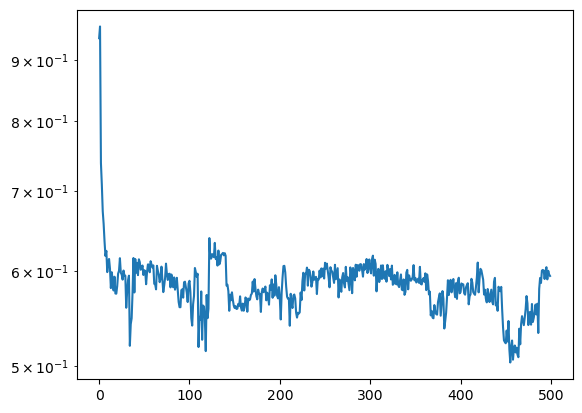

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:26,  2.96s/it]

 20%|██        | 2/10 [00:06<00:24,  3.02s/it]

 30%|███       | 3/10 [00:09<00:21,  3.04s/it]

 40%|████      | 4/10 [00:12<00:17,  2.99s/it]

 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

 60%|██████    | 6/10 [00:17<00:11,  2.93s/it]

 70%|███████   | 7/10 [00:20<00:08,  2.92s/it]

 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

100%|██████████| 10/10 [00:29<00:00,  2.97s/it]

100%|██████████| 10/10 [00:29<00:00,  2.95s/it]

Test Loss: 0.5778


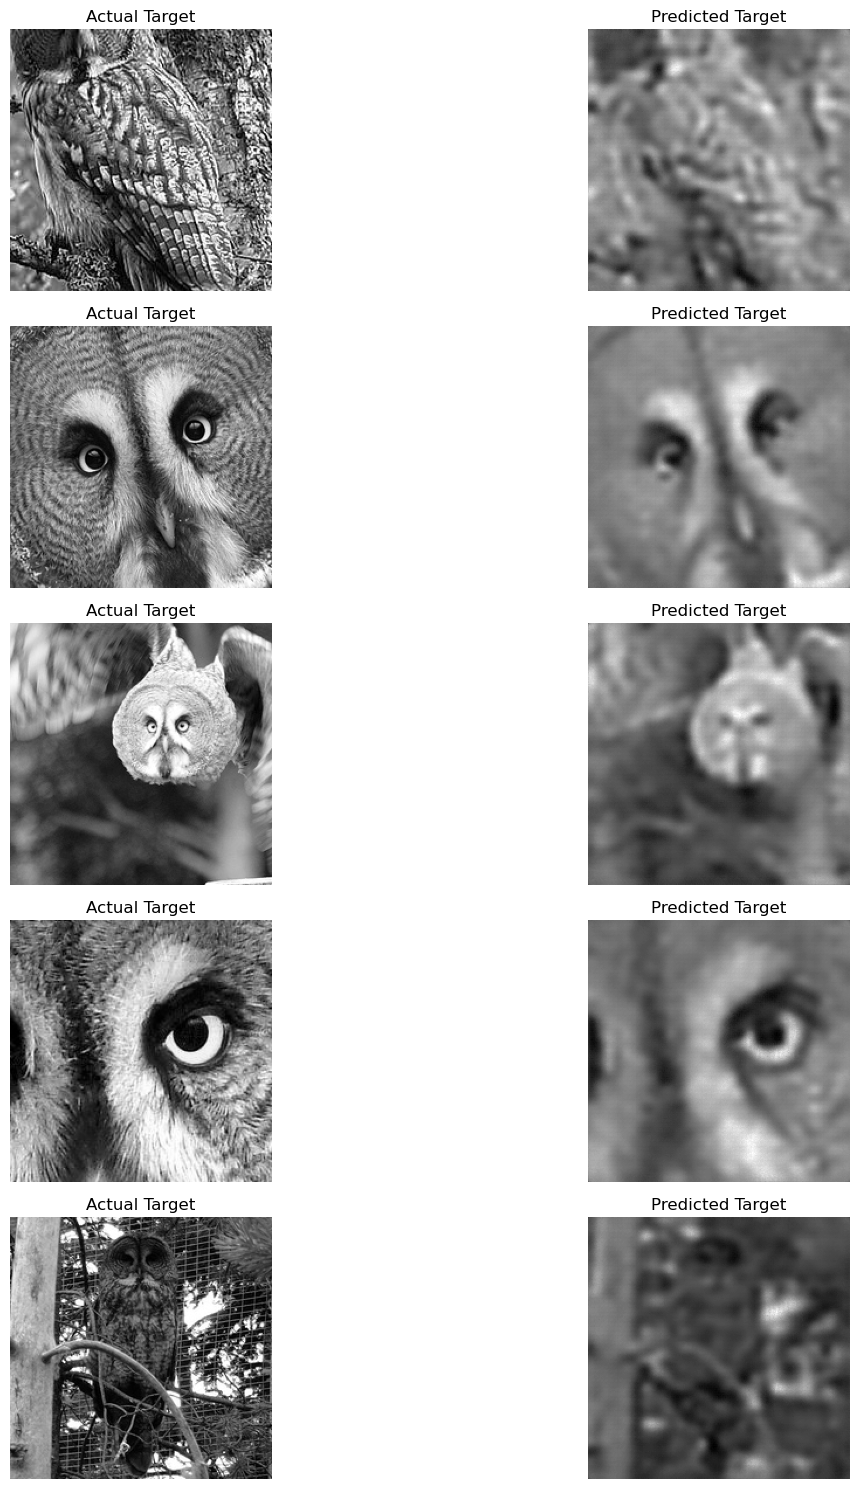

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-5.0025) tensor(8.8853)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))